In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 

In [2]:
def evaluate_model(predictions,actual):
    return pd.DataFrame({
        "Measures":["Accuracy","Recall","Precision"],
        "Score": [accuracy_score(actual,predictions),precision_score(actual,predictions),recall_score(actual,predictions)]
    })

def features_importance(columns,classifier):
    display("Feature importance")
    df = pd.DataFrame({
        "Features":columns,
        "Importance":classifier.feature_importances_
    })
    df = df.sort_values("Importance",ascending=False)
    ax = df.plot(kind="bar",x = "Features",y="Importance",legend=None)
    plt.tight_layout()
    plt.show()

In [3]:
#utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

In [4]:
# Load the adjacency matrix into a numpy array.
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
for i in range(0,70):
        normal_mat[i][i] = 0
G_Normal = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G_Normal.edges()))
print("Number Of Nodes: ",len(G_Normal.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [5]:
# Load the adjacency matrix into a numpy array.
eMCI_mat = np.loadtxt('../AD.txt', dtype=int)
for i in range(0,70):
        eMCI_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(eMCI_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1364
Number Of Nodes:  70


# Train model based on normal state

In [6]:
edges = list(G_Normal.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [7]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)
adj_G.shape
print("Number Of Edges: ",len(G.edges()))
print("Number Of Nodes: ",len(G.nodes()))

Number Of Edges:  1490
Number Of Nodes:  68


In [8]:
edges = list(G_Normal.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
print(len(node_list))

68


In [9]:
df_train = pd.DataFrame()
AA = []
PA = []
RAI = []
JC = []
CSH = []
RAISH = []
WIC = []
_node1 = []
_node2 = []
target = []
CN=[]

In [10]:
for i in node_list:
    for j in node_list:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])
            CN.append(len(list(nx.common_neighbors(G, i, j))))
            #CNC.append(list(nx.common_neighbor_centrality(G, ebunch=[(i, j)]))[0][2])
            if G.has_edge(i,j)==True:
                target.append(1)
            else:
                target.append(0)

In [11]:
df_train['node1'] = _node1
df_train['node2'] = _node2     
df_train['AA'] = AA     
df_train['RAI'] = RAI
df_train['PA'] = PA
df_train['JC'] = JC 
df_train['CN'] = CN
#df_train['CNC'] = CNC 
df_train['Target'] = target

In [12]:
df_train.head(5)

,node1,node2,AA,RAI,PA,JC,CN,Target
0,0,1,8.629530,0.725473,1813,0.622642,33,1
1,0,2,8.919526,0.757370,1850,0.641509,34,1
2,0,4,6.969278,0.563268,1295,0.600000,27,1
3,0,5,7.374409,0.633878,1147,0.700000,28,1
4,0,6,9.472994,0.812668,1702,0.765957,36,1


In [13]:
columns = ['AA','RAI','PA','JC','CN']
target = 'Target'

In [14]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [1,3,5,6,10],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,5,6,10],
    'n_estimators': [100, 200, 300, 500]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 3)

In [15]:
rf.fit(df_train[columns], df_train['Target'])
#grid_search.best_params_

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Test data on lmci state

In [16]:
edges = list(G_eMCI.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [17]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)
adj_G.shape
print("Number Of Edges: ",len(G.edges()))
print("Number Of Nodes: ",len(G.nodes()))

Number Of Edges:  1364
Number Of Nodes:  68


In [18]:
edges = list(G_eMCI.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
print(len(node_list))

68


In [19]:
df_Test = pd.DataFrame()
AA = []
PA = []
RAI = []
JC = []
CSH = []
RAISH = []
WIC = []
_node1 = []
_node2 = []
target = []
CN=[]

In [20]:
for i in node_list:
    for j in node_list:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])
            CN.append(len(list(nx.common_neighbors(G, i, j))))
            #CNC.append(list(nx.common_neighbor_centrality(G, ebunch=[(i, j)]))[0][2])
            if G.has_edge(i,j)==True:
                target.append(1)
            else:
                target.append(0)

In [21]:
df_Test['node1'] = _node1
df_Test['node2'] = _node2     
df_Test['AA'] = AA     
df_Test['RAI'] = RAI
df_Test['PA'] = PA
df_Test['JC'] = JC 
df_Test['CN'] = CN
#df_AllNodes['CNC'] = CNC 
df_Test['Target'] = target

In [22]:
df_Test.head()

,node1,node2,AA,RAI,PA,JC,CN,Target
0,0,1,7.427108,0.648640,1584,0.538462,28,1
1,0,2,8.624333,0.790268,1476,0.711111,32,1
2,0,4,7.220715,0.647017,1296,0.600000,27,1
3,0,5,6.428171,0.578452,900,0.648649,24,1
4,0,6,8.608197,0.785129,1404,0.744186,32,1


In [23]:
predictions_test = rf.predict(df_Test[columns])
predictions_train = rf.predict(df_train[columns])
actual_test = df_Test['Target']
actual_train = df_train['Target']

    Measures     Score
0   Accuracy  0.809482
1     Recall  0.829787
2  Precision  0.857771


'Feature importance'

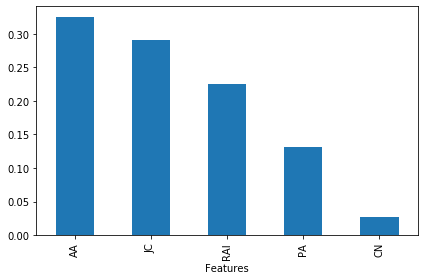

In [24]:
print(evaluate_model(predictions_test,actual_test))
features_importance(columns,rf)

    Measures     Score
0   Accuracy  0.999561
1     Recall  1.000000
2  Precision  0.999329


'Feature importance'

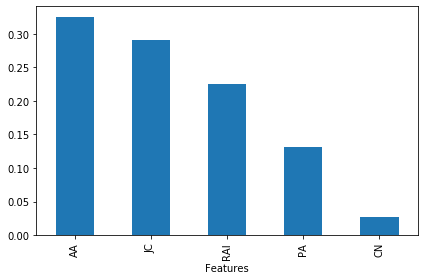

In [25]:
print(evaluate_model(predictions_train,actual_train))
features_importance(columns,rf)

In [26]:
print("Confusion matrix test: \n",confusion_matrix(df_Test['Target'],predictions_test))
print("Confusion matrix train: \n",confusion_matrix(df_train['Target'],predictions_train))

Confusion matrix test: 
 [[1348  480]
 [ 388 2340]]
Confusion matrix train: 
 [[1576    0]
 [   2 2978]]


In [27]:
prob = []
for item in rf.predict_proba(df_Test[['AA','RAI','PA','JC','CN']]):
    prob.append(item[1])
df_Test['pred'] = prob

## Model on Complement

In [28]:
G_Normal_complement = nx.complement(G_Normal)
print("Number Of Edges: ",len(G_Normal_complement.edges()))
print("Number Of Nodes: ",len(G_Normal_complement.nodes()))

Number Of Edges:  925
Number Of Nodes:  70


In [29]:
G_eMCI_Complement = nx.complement(G_eMCI)
print("Number of edges: ",len(G_eMCI_Complement.edges()))
print("Number of nodes: ",len(G_eMCI_Complement.nodes()))

Number of edges:  1051
Number of nodes:  70


# Training Model

In [30]:
edges = list(G_Normal_complement.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,3
1,0,25
2,0,31
3,0,35
4,0,36


In [31]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)
adj_G.shape
print("Number Of Edges: ",len(G.edges()))
print("Number Of Nodes: ",len(G.nodes()))

Number Of Edges:  925
Number Of Nodes:  70


In [32]:
edges = list(G_Normal_complement.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
print(len(node_list))

70


In [33]:
df_train_complement = pd.DataFrame()
AA = []
PA = []
RAI = []
JC = []
CSH = []
RAISH = []
WIC = []
_node1 = []
_node2 = []
target = []
CN=[]

In [34]:
for i in node_list:
    for j in node_list:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])
            CN.append(len(list(nx.common_neighbors(G, i, j))))
            #CNC.append(list(nx.common_neighbor_centrality(G, ebunch=[(i, j)]))[0][2])
            if G.has_edge(i,j)==True:
                target.append(1)
            else:
                target.append(0)

In [35]:
df_train_complement['node1'] = _node1
df_train_complement['node2'] = _node2     
df_train_complement['AA'] = AA     
df_train_complement['RAI'] = RAI
df_train_complement['PA'] = PA
df_train_complement['JC'] = JC 
df_train_complement['CN'] = CN
#df_train['CNC'] = CNC 
df_train_complement['Target'] = target

In [36]:
df_train_complement.head(5)

,node1,node2,AA,RAI,PA,JC,CN,Target
0,0,1,4.949195,0.560237,640,0.485714,17,0
1,0,2,4.883344,0.533737,608,0.500000,17,0
2,0,3,9.412797,1.168655,2208,0.442857,31,1
3,0,4,7.462221,0.897322,1088,0.609756,25,0
4,0,5,9.050551,1.111377,1216,0.750000,30,0


In [37]:
columns

['AA', 'RAI', 'PA', 'JC', 'CN']

In [38]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(df_train_complement[columns], df_train_complement['Target'])

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Test on next state

In [39]:
edges = list(G_eMCI_Complement.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,3
1,0,18
2,0,31
3,0,35
4,0,37


In [40]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)
adj_G.shape
print("Number Of Edges: ",len(G.edges()))
print("Number Of Nodes: ",len(G.nodes()))

Number Of Edges:  1051
Number Of Nodes:  70


In [41]:
edges = list(G_eMCI_Complement.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
print(len(node_list))

70


In [42]:
df_Test_Complement = pd.DataFrame()
AA = []
PA = []
RAI = []
JC = []
CSH = []
RAISH = []
WIC = []
_node1 = []
_node2 = []
target = []
CN=[]

In [43]:
for i in node_list:
    for j in node_list:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])
            CN.append(len(list(nx.common_neighbors(G, i, j))))
            #CNC.append(list(nx.common_neighbor_centrality(G, ebunch=[(i, j)]))[0][2])
            if G.has_edge(i,j)==True:
                target.append(1)
            else:
                target.append(0)

In [44]:
df_Test_Complement['node1'] = _node1
df_Test_Complement['node2'] = _node2     
df_Test_Complement['AA'] = AA     
df_Test_Complement['RAI'] = RAI
df_Test_Complement['PA'] = PA
df_Test_Complement['JC'] = JC 
df_Test_Complement['CN'] = CN
#df_AllNodes['CNC'] = CNC 
df_Test_Complement['Target'] = target

In [45]:
df_Test_Complement.head()

,node1,node2,AA,RAI,PA,JC,CN,Target
0,0,1,5.045143,0.516616,825,0.450000,18,0
1,0,2,7.129023,0.762614,924,0.694444,25,0
2,0,3,9.346974,1.061382,2277,0.457143,32,1
3,0,4,7.186373,0.789588,1089,0.609756,25,0
4,0,5,9.583151,1.075875,1452,0.750000,33,0


In [46]:
predictions_test = rf.predict(df_Test_Complement[['AA','RAI','PA','JC','CN']])
predictions_train = rf.predict(df_train_complement[['AA','RAI','PA','JC','CN']])
actual_test = df_Test_Complement['Target']
actual_train = df_train_complement['Target']

    Measures     Score
0   Accuracy  0.763975
1     Recall  0.850073
2  Precision  0.555661


'Feature importance'

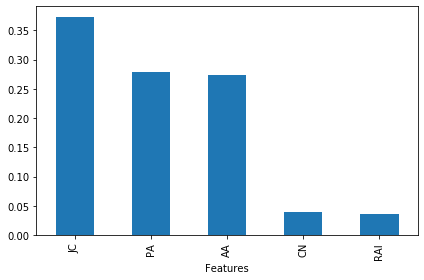

In [47]:
print(evaluate_model(predictions_test,actual_test))
features_importance(columns,rf)

    Measures     Score
0   Accuracy  0.821118
1     Recall  0.854676
2  Precision  0.642162


'Feature importance'

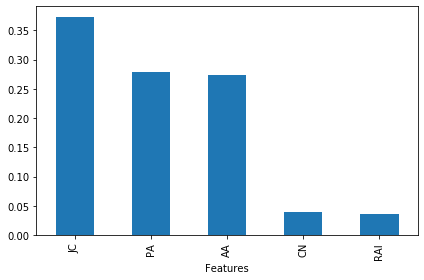

In [48]:
print(evaluate_model(predictions_train,actual_train))
features_importance(columns,rf)

In [49]:
print("Confusion matrix test: \n",confusion_matrix(df_Test_Complement['Target'],predictions_test))
print("Confusion matrix train: \n",confusion_matrix(df_train_complement['Target'],predictions_train))

Confusion matrix test: 
 [[2522  206]
 [ 934 1168]]
Confusion matrix train: 
 [[2778  202]
 [ 662 1188]]


In [50]:
prob = []
for item in rf.predict_proba(df_Test_Complement[['AA','RAI','PA','JC','CN']]):
    prob.append(item[1])
df_Test_Complement['pred'] = prob

# MLP with prob as a score

In [51]:
df_Test.head()

,node1,node2,AA,RAI,PA,JC,CN,Target,pred
0,0,1,7.427108,0.648640,1584,0.538462,28,1,1.0
1,0,2,8.624333,0.790268,1476,0.711111,32,1,1.0
2,0,4,7.220715,0.647017,1296,0.600000,27,1,1.0
3,0,5,6.428171,0.578452,900,0.648649,24,1,1.0
4,0,6,8.608197,0.785129,1404,0.744186,32,1,1.0


In [52]:
df_Test_Complement.head()

,node1,node2,AA,RAI,PA,JC,CN,Target,pred
0,0,1,5.045143,0.516616,825,0.450000,18,0,0.190773
1,0,2,7.129023,0.762614,924,0.694444,25,0,0.221325
2,0,3,9.346974,1.061382,2277,0.457143,32,1,0.431495
3,0,4,7.186373,0.789588,1089,0.609756,25,0,0.251989
4,0,5,9.583151,1.075875,1452,0.750000,33,0,0.431495


In [53]:
#utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

In [54]:
def linkPredictWithAdamic(first,second):
    #loading matrix of first state
    normal_mat = np.loadtxt(first, dtype=int)
    #removing self loops
    for i in range(0,70):
            normal_mat[i][i] = 0
    #bilding graphs
    G_Normal = nx.from_numpy_matrix(normal_mat)
    print("Number Of Edges: ",len(G_Normal.edges()))
    print("Number Of Nodes: ",len(G_Normal.nodes()))
    #loading matrix of second state
    emci_mat = np.loadtxt(second, dtype=int)
    #removing self loops
    for i in range(0,70):
        emci_mat[i][i] = 0
    #building graph of second state
    G_eMCI = nx.from_numpy_matrix(emci_mat)
    #G_lMCI = nx.from_numpy_matrix(lmci_mat)
    print("Number Of Edges: ",len(G_eMCI.edges()))
    print("Number Of Nodes: ",len(G_eMCI.nodes()))
    print("Number Of Removed Edges: ",removedEdges(G_Normal.edges(),G_eMCI.edges()))
    print("Number of new Edges:",addedEdges(G_Normal.edges(),G_eMCI.edges()))
    #print(emci_mat)
    #print(type(emci_mat))
    ecmi_pred = emci_mat.copy()
    #prepare the positive score matrix
    #pred_adamic = list(nx.adamic_adar_index(G_Normal))
    positive_score_mat = np.zeros((70,70))
    for i,j,k in zip(df_Test['node1'],df_Test['node2'],df_Test['pred']):
        positive_score_mat[i][j] = k

    #preparing negative score matrix
    G_Normal_complement = nx.complement(G_Normal)
    #pred_adamic = list(nx.adamic_adar_index(G_Normal_complement))
    negative_score_mat = np.zeros((70,70))
    for i,j,k in zip(df_Test_Complement['node1'],df_Test_Complement['node2'],df_Test_Complement['pred']):
        negative_score_mat[i][j] = k
    A = addedEdges(G_Normal.edges(),G_eMCI.edges())
    B = removedEdges(G_Normal.edges(),G_eMCI.edges())
    score=(A+B)*2
    
    done = []
    while(A>0 and B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    #print(i,j)
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
        #positive_score_mat[x][y] = -positive_score_mat[x][y]
        if(positive_score_mat[x][y]>negative_score_mat[x][y]):
            #adding link
            ecmi_pred[x][y] = 1
            A-=1
            
            done.append((x,y))
        elif(ecmi_pred[x][y]==1):
            #removing edge
            ecmi_pred[x][y] = 0
            B-=1
            print(x,y)
            done.append((x,y))
        else:
            done.append((x,y))
    
        
    
    while(A>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 1
        A-=1
        done.append((x,y))
        print(x,y)
    while(B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==1 and (i,j) not in done):
                    tempRank = negative_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 0
        B-=1
        done.append((x,y))
    diff = np.subtract(emci_mat,ecmi_pred)    
    dist = 0
    for i in range(70):
        for j in range(i,70):
            if diff[i][j]!=0:
                dist+=1
    print("score: ",score)
    matching  = (score-dist)/score
    print("Matching Score:: ",matching)
    print(len(done))

In [55]:
linkPredictWithAdamic('../Normal.txt','../AD.txt')

Number Of Edges:  1490
Number Of Nodes:  70
Number Of Edges:  1364
Number Of Nodes:  70
Number Of Removed Edges:  172
Number of new Edges: 46
score:  436
Matching Score::  0.7018348623853211
218
